# CS 5824 Final Project (Matt Harrington and Taehwan Kim)
### Using smart beta factors as input for Random Forest time series classification. 

> "Machine Learning in finance is like using an image classifier to identify a zebra, and the zebra is constantly changing colors." - Michael Kearns

Herein, we aim to identify periods where the zebra's colors are consistant, using smart beta factors as input to time series classification methods.

In [23]:
# Import necessary libraries

# !pip3 install tslearn
import numpy as np
from datetime import datetime as date
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance
from google.colab import files
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans


## Data Collection

In [2]:
# Obtain data (upload all 11 csv files)
# cboe_vix.csv, corporate_bond_yeild.xls, dollar_index.csv, Golbal_Alignment_Kernel_Labels.csv
# monetary_base.csv, oil.csv, TIPS.csv, treasury_bond.csv, Year_1.csv, Year_2.csv, Year_10.csv
uploaded = files.upload() 

Saving cboe_vix.csv to cboe_vix.csv
Saving corporate_bond_yield.xls to corporate_bond_yield.xls
Saving dollar_index.csv to dollar_index.csv
Saving Global_Alignment_Kernel_Labels.csv to Global_Alignment_Kernel_Labels.csv
Saving monetary_base.csv to monetary_base.csv
Saving oil.csv to oil.csv
Saving TIPS.csv to TIPS.csv
Saving treasury_bond.csv to treasury_bond.csv
Saving Year_1.csv to Year_1.csv
Saving Year_2.csv to Year_2.csv
Saving Year_10.csv to Year_10.csv


In [43]:
# Obtain Credit Spread Data
def calculate_credit_spread(treasury_bond):
  corporate_bond_yield = pd.read_excel("corporate_bond_yield.xls")[10:]
  corporate_bond_yield = corporate_bond_yield.rename(columns={'FRED Graph Observations':'month',
                                                              'Unnamed: 1':'value'})
  corporate_bond_yield['month'] = pd.to_datetime(corporate_bond_yield['month'], format='%Y-%m')
  corporate_bond_yield = corporate_bond_yield.set_index('month')

  start_date = corporate_bond_yield.index.min() - pd.DateOffset(day=1)
  end_date = corporate_bond_yield.index.max() + pd.DateOffset(day=31)

  dates = pd.date_range(start_date, end_date, freq='D')
  dates.name = 'date'
  corporate_bond_yield = corporate_bond_yield.reindex(dates, method='ffill')
  treasury_bond = treasury_bond.set_index('Date')
  credit_spread = treasury_bond.join(corporate_bond_yield)
  credit_spread['credit_spread'] = credit_spread['value'] - credit_spread['Close']
  credit_spread = credit_spread[['credit_spread']]

  return credit_spread

# Obtain Monetary Base Data
def get_monetary_base():
	monetary_base = pd.read_csv("monetary_base.csv")
	monetary_base = monetary_base.rename(columns={'BOGMBASE':'monetary_base'})
	monetary_base['DATE'] = pd.to_datetime(monetary_base['DATE'], format='%Y-%m')
	monetary_base = monetary_base.set_index('DATE')
	start_date = monetary_base.index.min() - pd.DateOffset(day=1)
	end_date = monetary_base.index.max() + pd.DateOffset(day=31)

	dates = pd.date_range(start_date, end_date, freq='D')
	dates.name = 'Date'
	monetary_base = monetary_base.reindex(dates, method='ffill')

	return monetary_base  	

# Obtain Period Spread Data
def get_period_spread():
  Year_2 = pd.read_csv("Year_2.csv")[['Date','Price']]
  Year_10 = pd.read_csv("Year_10.csv")[['Date','Price']]
  Year_2['Date'] = pd.to_datetime(Year_2['Date'], format='%b %d, %Y')
  Year_10['Date'] = pd.to_datetime(Year_10['Date'], format='%b %d, %Y')
  period_spread = pd.merge(Year_2, Year_10, on='Date')
  period_spread['value'] = period_spread['Price_x'] - period_spread['Price_y']
  period_spread = period_spread.set_index(['Date'])
  period_spread = period_spread[['value']]
  period_spread = period_spread.rename(columns = {'value' : 'period_spread'})

  return period_spread  

# Obtain US Bond Data
def get_US_bond():
	Year_1 = pd.read_csv("Year_1.csv")[['Date','Price']]
	Year_2 = pd.read_csv("Year_2.csv")[['Date','Price']]
	Year_10 = pd.read_csv("Year_10.csv")[['Date','Price']]

	Year_1['Date'] = pd.to_datetime(Year_1['Date'], format='%b %d, %Y')
	Year_2['Date'] = pd.to_datetime(Year_2['Date'], format='%b %d, %Y')
	Year_10['Date'] = pd.to_datetime(Year_10['Date'], format='%b %d, %Y')

	Year_1 = Year_1.rename(columns={'Price' : 'Year_1'})
	Year_2 = Year_2.rename(columns={'Price' : 'Year_2'})
	Year_10 = Year_10.rename(columns={'Price' : 'Year_10'})

	Year_1 = Year_1.set_index(['Date'])
	Year_2 = Year_2.set_index(['Date'])
	Year_10 = Year_10.set_index(['Date'])

	return Year_1, Year_2, Year_10 

# Obtain TIPS Data
def get_TIPS():
	TIPS = pd.read_csv('TIPS.csv')
	TIPS['DATE'] = pd.to_datetime(TIPS['DATE'], format='%Y-%m-%d')
	TIPS = TIPS.rename(columns={'T5YIE':'value'})
	TIPS = TIPS.set_index(['DATE'])
  
	return TIPS

# Obtain Clustering Results
def get_labels():
	labels = pd.read_csv('Global_Alignment_Kernel_Labels.csv')
	labels = labels.set_index(['Date'])
	labels = labels.rename(columns={'Kernel_4':'labels'})

	return labels
	
# Merge 10 Data Sets
def merge_data(VIX, dollar, oil, credit_spread, monetary_base, period_spread, Year_1, Year_2, Year_10, TIPS, labels):
	data_frames = [VIX, dollar, oil, credit_spread, monetary_base, period_spread, Year_1, Year_2, Year_10, TIPS]
	df_merged = reduce(lambda  left,right: pd.merge(left, right, left_index=True, right_index=True,
                                            how='inner'), data_frames)
	df_merged = df_merged.dropna()

	# Drop string and change it to pct_change
	df_merged = df_merged.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
	df_merged = df_merged.pct_change().dropna()
	df_merged = pd.merge(df_merged, labels, left_index=True, right_index=True,
	                                            how='inner')

	return df_merged

## Clustering

In [33]:
# percentage change and log change (data processing)
def process_data(vix, oil, dollar):
  df = pd.concat([vix, oil, dollar], axis=1)
  df = df.dropna()
  df.index = pd.to_datetime(df.index)

  #removing oil spike on last two days
  df_change = df.pct_change().dropna().iloc[:-2] 
  df_log_change = np.log(df).diff().dropna()

  # Removing first row to align with labels, and remove oil spike
  df = df.iloc[1:]

  return df, df_change, df_log_change

# plot raw oil, vix, and dollar data
def plot_raw(df):
  plt.style.use('ggplot')
  fig = plt.figure(figsize=(20,10))
  for c in df.columns:
      plt.plot(df[c], label=c)
  plt.title("Prices of MacroEconomic Indices")
  plt.ylabel("Price ($)")
  plt.legend()
  plt.show()

# plot heatmap of the three variables
def plot_heatmap(df):
  plt.figure(figsize=(8,8))
  sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap='plasma')
  plt.title("Correlation Heatmap")
  plt.show()

def gen_repeating(s):
	"""Generator: groups repeated elements in an iterable
	E.g.
	    'abbccc' -> [('a', 0, 0), ('b', 1, 2), ('c', 3, 5)]
	"""
	i = 0
	while i < len(s):
	    j = i
	    while j < len(s) and s[j] == s[i]:
	        j += 1
	    yield (s[i], i, j-1)
	    i = j

def plot_colored_data(df, data, colors):
	n_data = len(data)
	n_colors = len(colors)

	plt.style.use('ggplot')    

	for i, col in enumerate(data):
	    for j, color in enumerate(colors):

	        fig, ax = plt.subplots(figsize=(15,10))
	        ## Add lines
	        for c, start, end in gen_repeating(df[color]):
	            
	            # print(c, start, end)

	            if start > 0: # make sure lines connect
	                start -= 1
	            
	            idx = df.index[start : end+1]
	            plt.plot(df.loc[idx, col], color=c, linewidth=2.0)
	            plt.title("{} with {}".format(col, color))
	            # df.loc[idx, col].plot(ax=ax, color=c)

	        plt.show()

# group returns for oil, vix, dollar
def show_grouped_returns(df_change, df, cols, labels, NUM_CLUSTERS=4):
    for l in labels:
        groups = df_change.groupby(df[l])
        for col in cols:
            fig, ax = plt.subplots(NUM_CLUSTERS, 1, figsize=(12,8))
            fig.suptitle("Return Distribution for {} in {} Clusters".format(col, l))
            for i, g in enumerate(groups):
                dat = g[1]
                c = g[0]
                x = dat[col]
                ax[i].plot(range(0, len(x)), x, color=c)
                ax[i].set_ylabel("{} points".format(len(dat)))    
                ax[i].grid(True)
            plt.show()

# cumulative returns for oil, vix, dollar
def show_grouped_cumulative_return(df_change, df, cols, labels, NUM_CLUSTERS=4):
    for l in labels:
        groups = df_change.groupby(df[l])
        for col in cols:
            fig, ax = plt.subplots(NUM_CLUSTERS,2, figsize=(15,12))
            fig.suptitle("Returns for {} in {} Clusters".format(col, l))
            for i, g in enumerate(groups):
                dat = g[1]
                c = g[0]
                x = dat[col]
                rets = np.zeros(len(x))
                for r in range(0, len(x)):
                    ret = 1 + x[r]
                    if r == 0:
                        rets[r] = ret
                    else:
                        rets[r] = rets[r-1] * ret
                ax[i, 0].plot(range(0, len(x)), x, color=c)
                ax[i, 1].plot(range(0, len(rets)), rets, color=c)
                ax[i, 0].set_ylabel("{} returns".format(len(dat)))    
                ax[i, 0].grid(True)
                ax[i, 1].grid(True)
            ax[0, 0].set_title('{} Returns'.format(col))
            ax[0, 1].set_title('{} Cumulative Return'.format(col))
            plt.show()

# Time series data clustering models (Test 3 models)
def cluster_time_series(data, model, NUM_CLUSTERS=4):
  # tslearn time_series dataset
  ts = to_time_series_dataset(df_log_change)

  # Kernel K Means clustering
  if model == "kernelkmeans":
    gak_km = KernelKMeans(n_clusters = NUM_CLUSTERS, 
                          kernel='gak', 
                          kernel_params={'sigma': 'auto'})
    labels = gak_km.fit_predict(ts)
  
  # DTW TS KMeans clustering
  if model == "DTW_TS_KMeans":
    km = TimeSeriesKMeans(n_clusters = NUM_CLUSTERS, metric = 'dtw')
    labels = km.fit_predict(ts)

  # SoftDTW TS Kmeans
  if model == "SoftDTW_TS_KMeans":
    km_bis = TimeSeriesKMeans(n_clusters = NUM_CLUSTERS, metric = 'softdtw')
    labels = km_bis.fit_predict(ts)
  
  return labels

# combine the labels with the original dataframe
def combine_data_labels(df, gak_labels, km_labels, bis_labels, NUM_CLUSTERS=4):
  CLOSES = ['VIX', 'OIL', 'DOLLAR']
  color_mapping = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4:'grey'}

  # Grouping label columns
  kernel_l = f'Kernel_{NUM_CLUSTERS}'
  kernel_c = f'Kernel_colors_{NUM_CLUSTERS}'
  dtw_l = f'Kmeans_dtw_{NUM_CLUSTERS}' # label_i \in {0, 1, 2, ...}
  dtw_c = f'Kmeans_dtw_colors_{NUM_CLUSTERS}' # label_i \in {red, blue, yellow, green, ... }
  softdtw_l = f'Kmeans_softdtw_{NUM_CLUSTERS}'
  softdtw_c = f'Kmeans_softdtw_colors_{NUM_CLUSTERS}'

  # Create color label columns
  df[kernel_l] = gak_labels
  df[kernel_c] = df[kernel_l].map(color_mapping).astype(str)

  df[dtw_l] = km_labels
  df[dtw_c] = df[dtw_l].map(color_mapping).astype(str)

  df[softdtw_l] = bis_labels
  df[softdtw_c] = df[softdtw_l].map(color_mapping).astype(str)

  LABELS = [kernel_l, dtw_l, softdtw_l]
  COLORS = [kernel_c, dtw_c, softdtw_c]

  return df, CLOSES, COLORS

## XGBoost Modeling (grid search and 10 CV)

In [5]:
# XGBoost Modeling
class XGBoost():

	def __init__(self, data, learning_rate=0.01, max_depth=8, colsample_bytree=1, n_estimators=50, 
               grid=False, alpha=2):
		self.learning_rate = learning_rate
		self.max_depth = max_depth
		self.colsample_bytree = colsample_bytree
		self.alpha = alpha
		self.n_estimators = n_estimators
		self.data = data
		self.grid = grid
		self.get_data()
    # when grid search, grid=True
		if self.grid:
		  train_acc, val_acc, test_acc, param = self.grid_search()
		  print(train_acc, val_acc, test_acc, param)
		else:
		  self.model = self.build_model(self.colsample_bytree, self.max_depth, self.alpha, self.n_estimators)
		  res = self.train(self.model)
		  self.training_acc_cv = res['train']
		  self.testing_acc_cv = res['test']

  # split the data into 80:20 (training:testing) and further 80:20 (testing:validation) 
	def get_data(self):
		X,y = np.array(self.data.iloc[:,:-1]), np.array(self.data.iloc[:,-1])
		X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
		self.train_x = X_train[:int(len(X_train)*0.8)]
		self.train_y = y_train[:int(len(X_train)*0.8)]
		self.test_x = X_test
		self.test_y = y_test
		self.valid_x = X_train[int(len(X_train)*0.8):]
		self.valid_y = y_train[int(len(X_train)*0.8):]
		self.X = X
		self.y = y
  
  # Build XGBoost classifier (built in library)
	def build_model(self, colsample_bytree,
                  max_depth, alpha, n_estimators):
    
		model = xgb.XGBClassifier(colsample_bytree=colsample_bytree, learning_rate=self.learning_rate,
		                          max_depth=max_depth, alpha=alpha, n_estimators=n_estimators)
		return model
    
	def train(self, model):
		# if you are using gridsearch
		res = {'train':[], 'valid':[], 'test':[]}
		if self.grid:
		  model.fit(self.train_x, self.train_y, eval_set=[(self.valid_x, self.valid_y)], verbose=0)
		  res['train'].append(self.test(self.train_x, self.train_y, model))
		  res['valid'].append(self.test(self.valid_x, self.valid_y, model))
		  res['test'].append(self.test(self.test_x, self.test_y, model))

		# 10 cross validation
		else:
		  tsvc = TimeSeriesSplit(n_splits=10)
		  for train_index, test_index in tsvc.split(self.X):
		    X_train, X_test = self.X[train_index], self.X[test_index]
		    y_train, y_test = self.y[train_index], self.y[test_index]
		    model.fit(X_train, y_train, verbose=0)
		    res['train'].append(self.test(X_train, y_train, model))
		    res['test'].append(self.test(X_test, y_test, model))
		  
		return res

  # Check the accuracy of the model (for each class)
	def test(self, X, y, model):
		y_pred = model.predict(X)
		clswise_acc = []
		for c in range(4):
		    ind = (y==c)
		    acc = (y_pred[ind]==y[ind]).sum()/ind.sum()*100
		    clswise_acc.append(acc) 
		return np.nanmean(clswise_acc)
  
  # Grid search for 4 hyper parameters
	def grid_search(self):
		bylevel_l = [0.2,0.5,1]
		depth_l = [2,5,8,10]
		alpha_l = [2,5,10]
		n_estimators = [50,100,150]
		val_acc = float('-inf')
		for b in bylevel_l:
		  for d in depth_l:
		    for a in alpha_l:
		      for n in n_estimators:
		        model = self.build_model(b, d, a, n)
		        res = self.train(model)
		        if res['valid'][0] > val_acc:
		          val_acc = res['valid'][0]
		          train_acc = res['train'][0]
		          test_acc = res['test'][0]
		          param = {'bylevel' : b, 
		                   'depth' : d,
		                   'alpha' : a,
		                   'estimators' : n}
		return train_acc, val_acc, test_acc, param

## Main Function (executes all the functions in order)

In [44]:
# Gather and process macroscopic data sets
vix = pd.read_csv('cboe_vix.csv', index_col='Date', names=['Date', 'VIX'], header=0)
oil = pd.read_csv('oil.csv', index_col='Date', names=['Date', 'OIL'], header=0)
dollar = pd.read_csv('dollar_index.csv', index_col='Date', names=['Date', 'DOLLAR'], header=0)
vix.index = pd.to_datetime(vix.index)
oil.index = pd.to_datetime(oil.index) 
dollar.index = pd.to_datetime(dollar.index)
treasury_bond = pd.read_csv("treasury_bond.csv") 
credit_spread = calculate_credit_spread(treasury_bond)
monetary_base = get_monetary_base()
period_spread = get_period_spread()
Year_1, Year_2, Year_10 = get_US_bond()
TIPS = get_TIPS()
labels = get_labels()

In [19]:
# Clustering 
df, df_change, df_log_change = process_data(vix, oil, dollar)

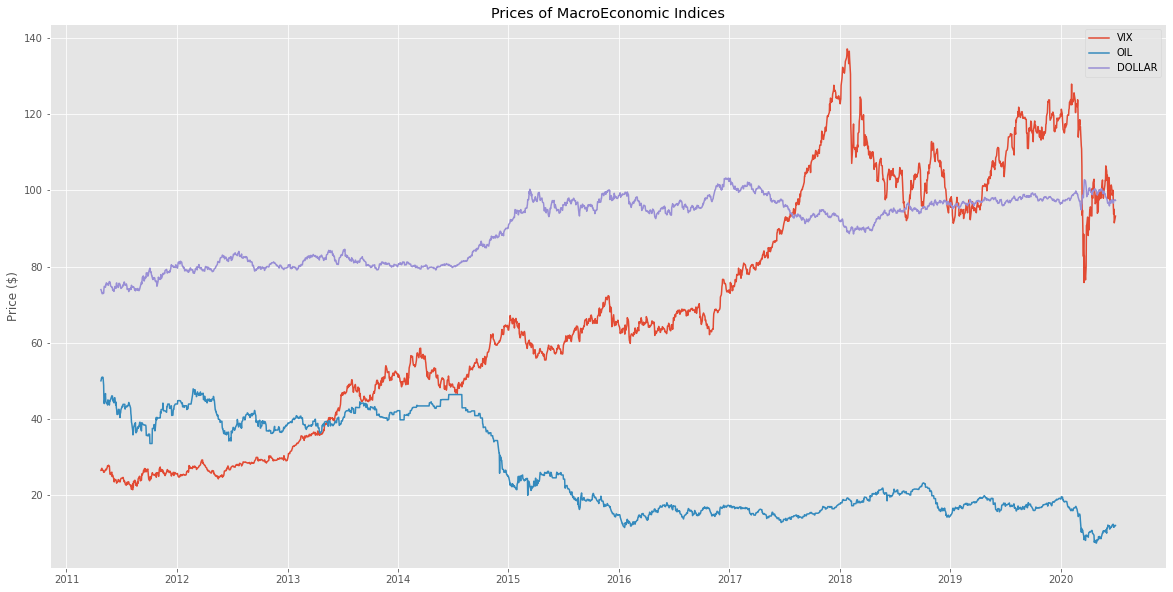

In [20]:
# Plot raw vix, oil, and dollar data
plot_raw(df)

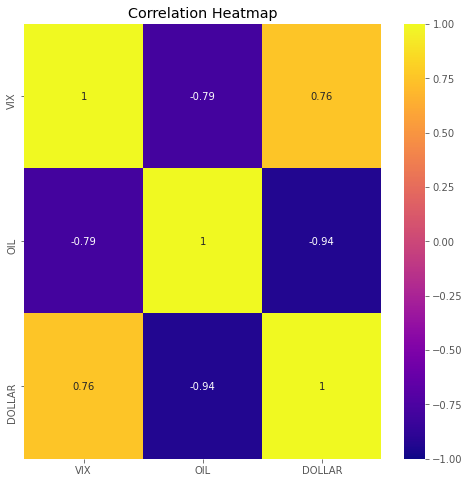

In [21]:
# Plot heatmap of vix, oil, and dollar data
plot_heatmap(df)

In [24]:
# Cluster Time Series (log_change)
# Three models (arguments : "kernelkmeans", "DTW_TS_KMeans", "SoftDTW_TS_KMeans")
# return the labels (0,1,2,3) for each time step
gak_labels = cluster_time_series(df_log_change, "kernelkmeans")
km_labels = cluster_time_series(df_log_change, "DTW_TS_KMeans")
bis_labels = cluster_time_series(df_log_change, "SoftDTW_TS_KMeans")

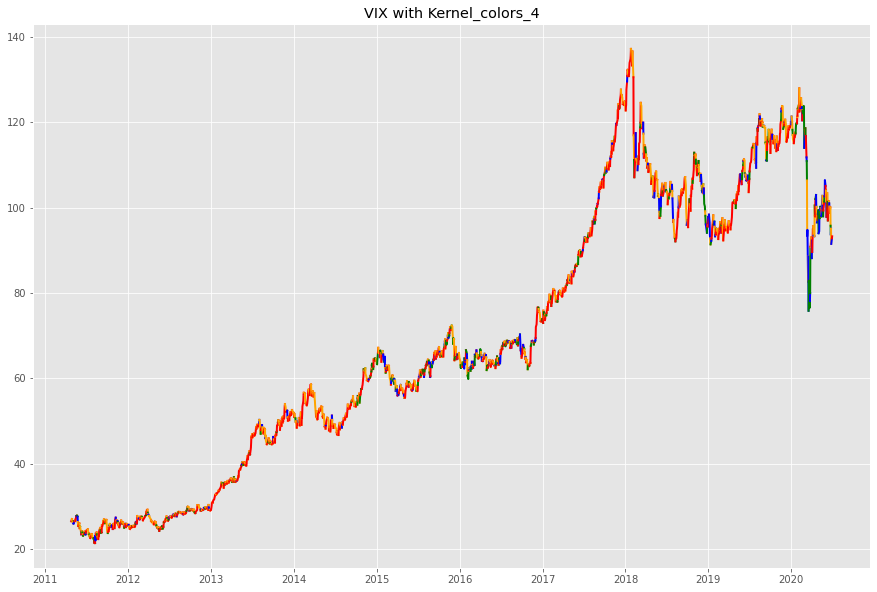

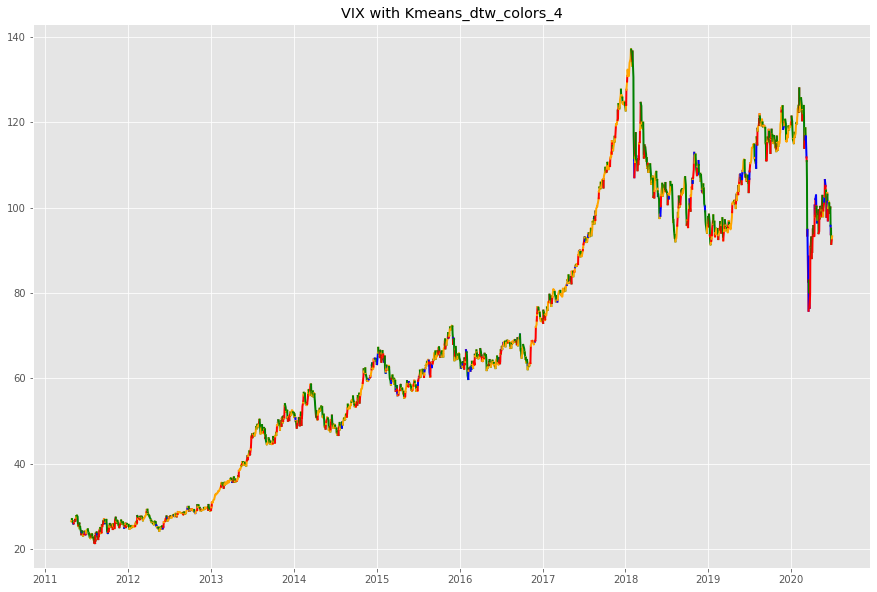

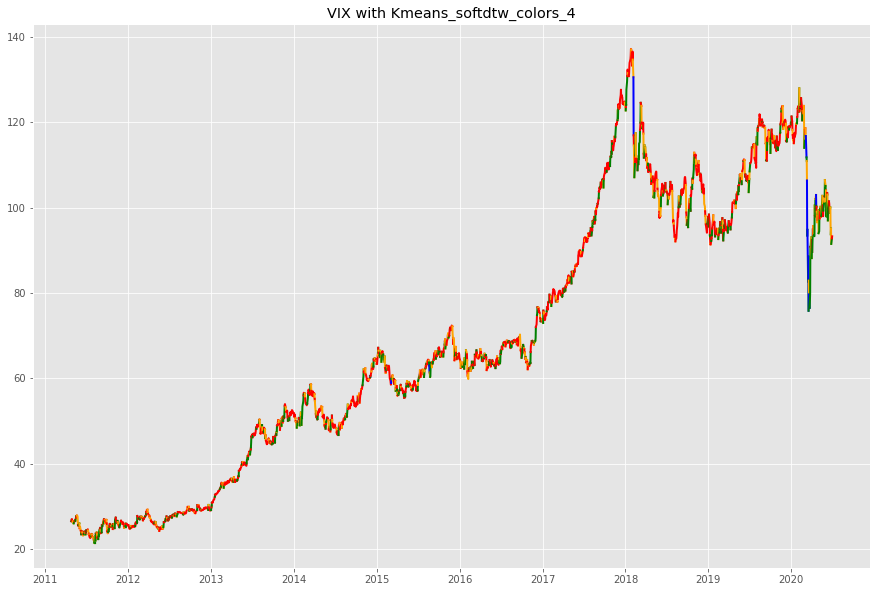

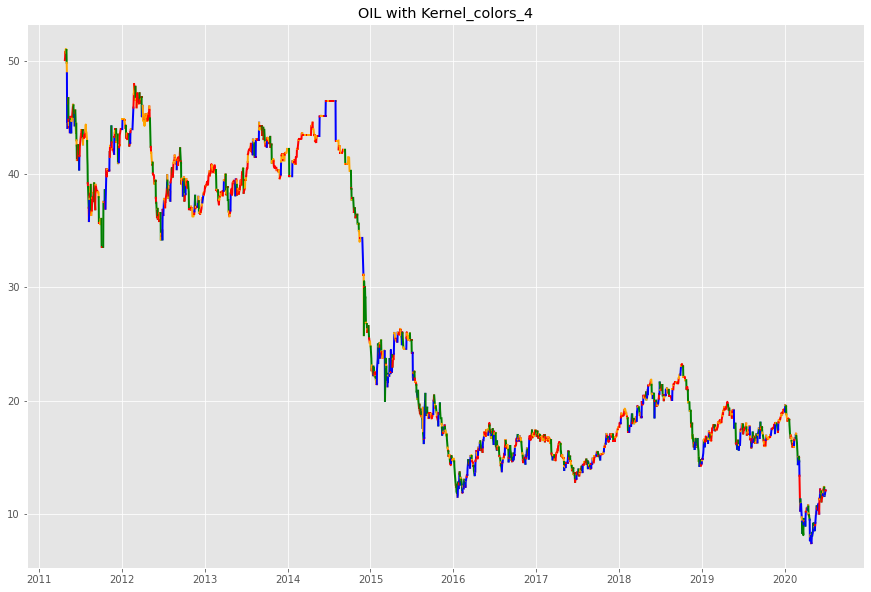

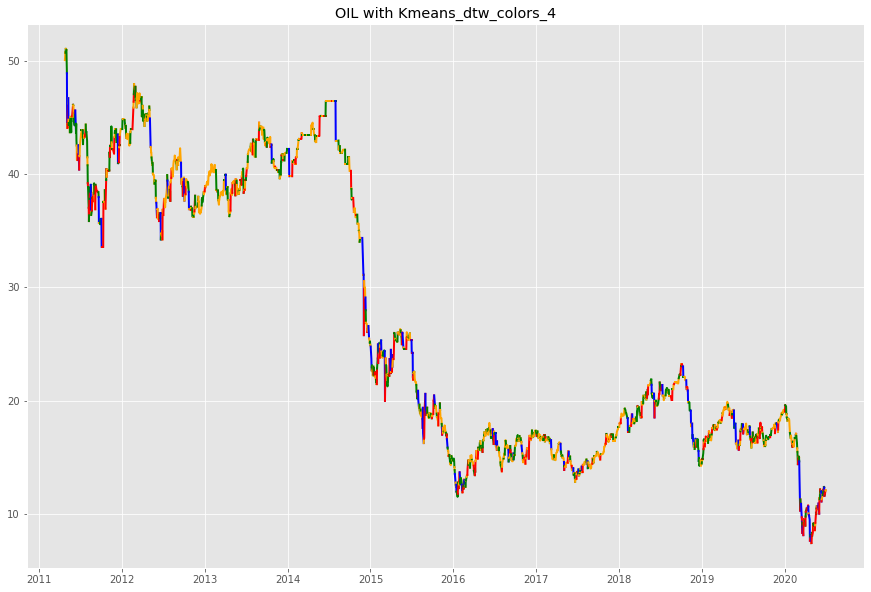

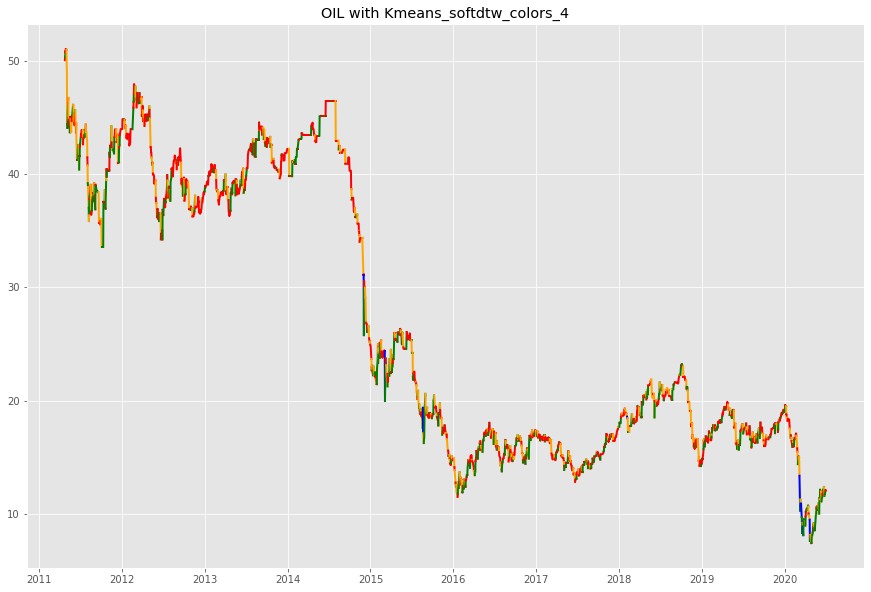

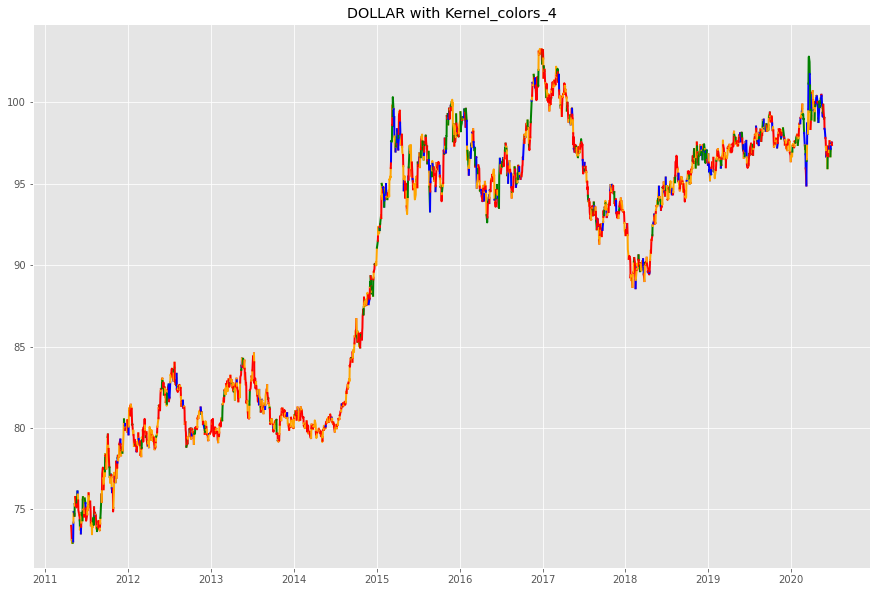

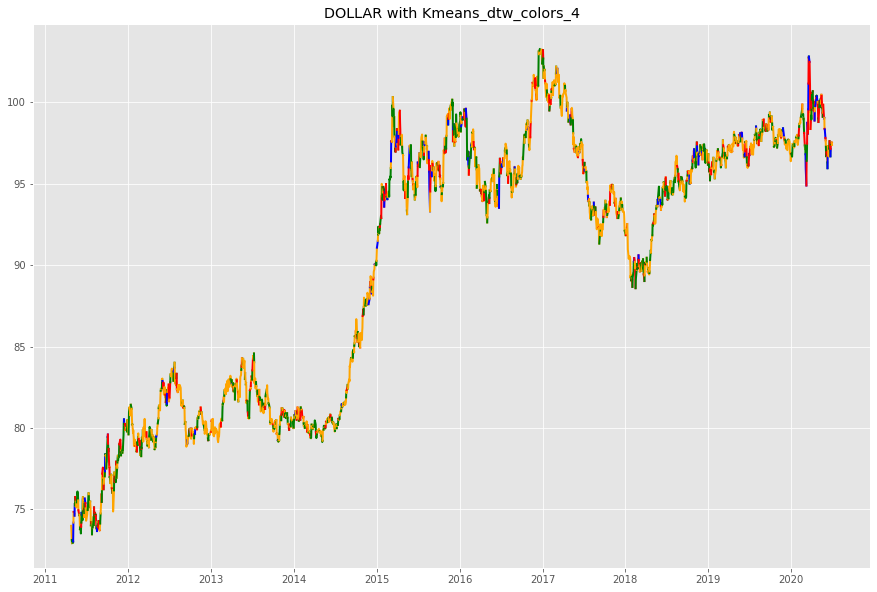

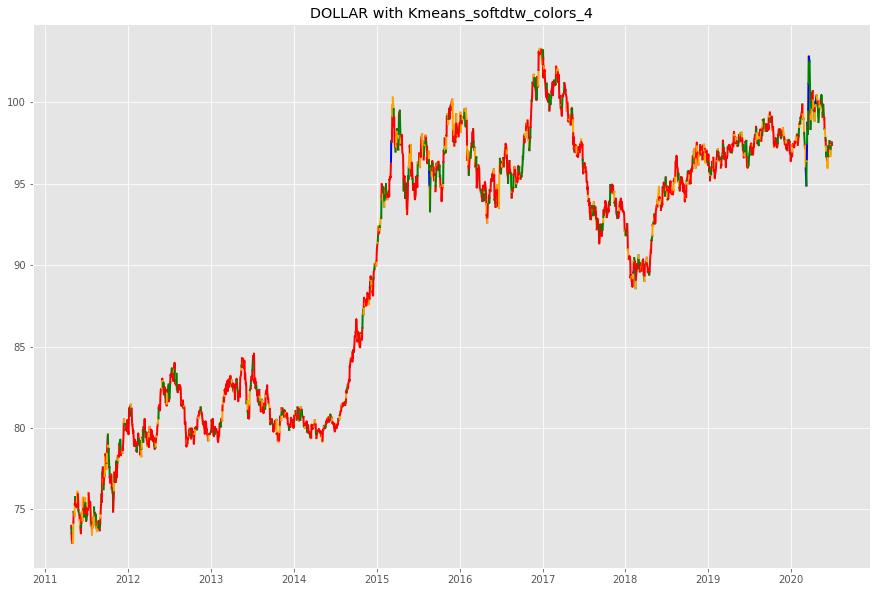

In [31]:
# Graph the label results
df, CLOSES, COLORS = combine_data_labels(df, gak_labels, km_labels, bis_labels)

# show raw data with label results
plot_colored_data(df, CLOSES, COLORS)

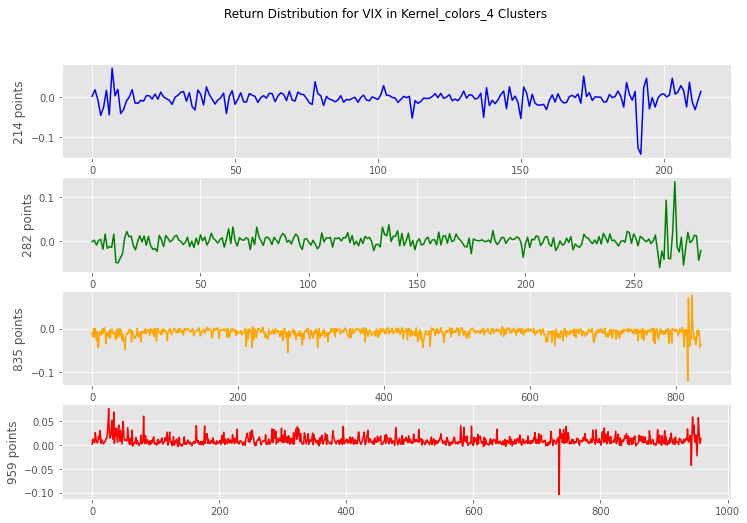

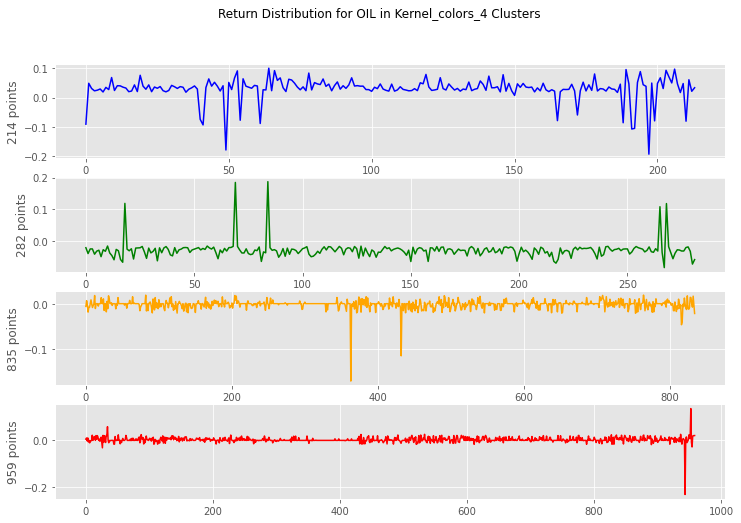

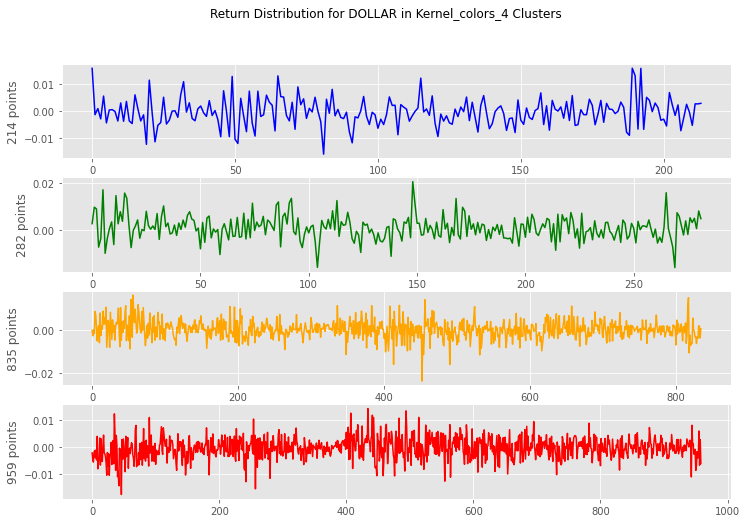

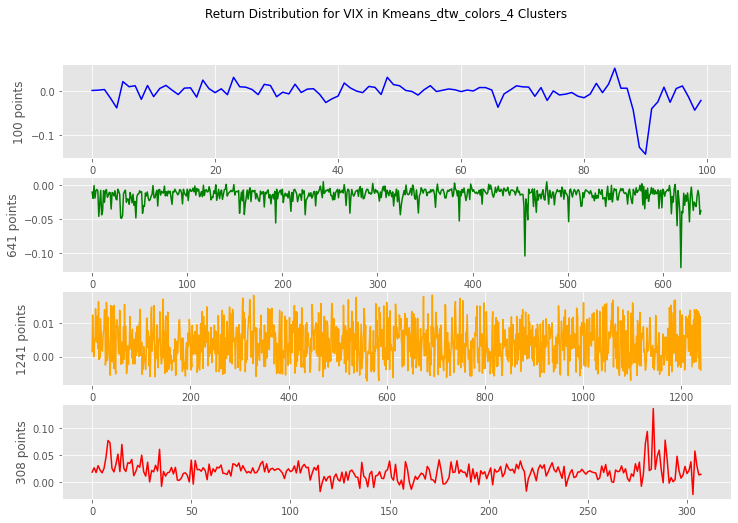

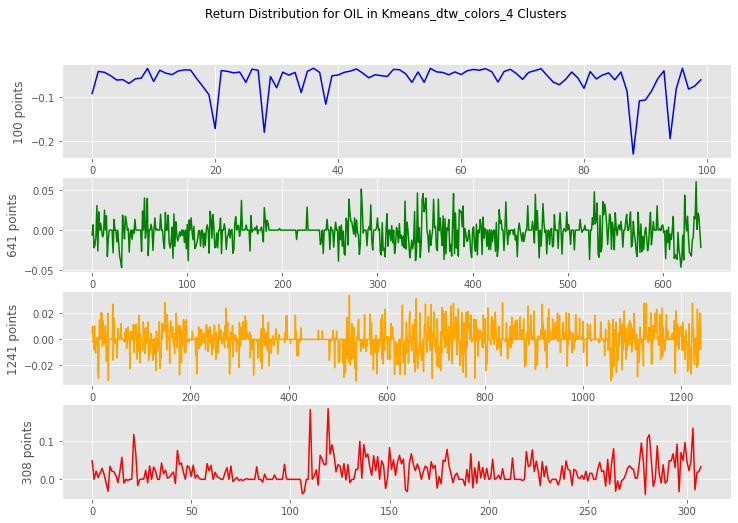

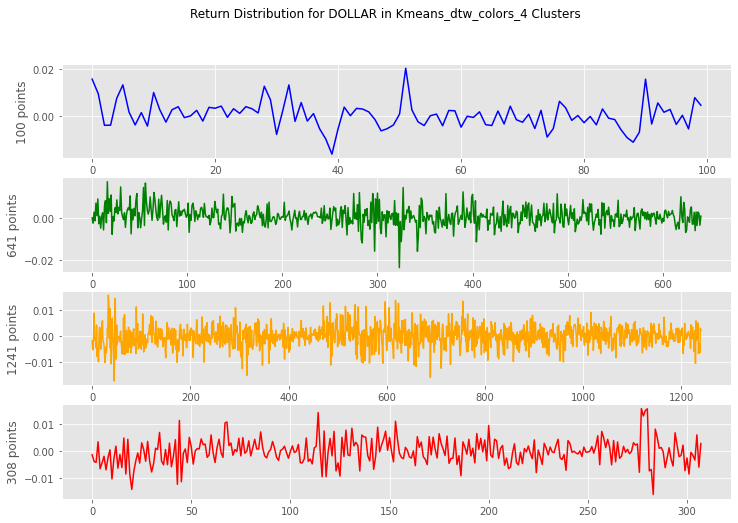

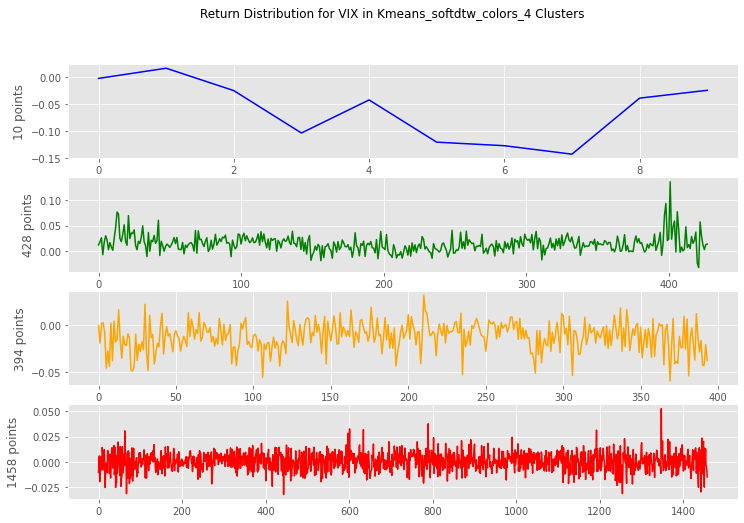

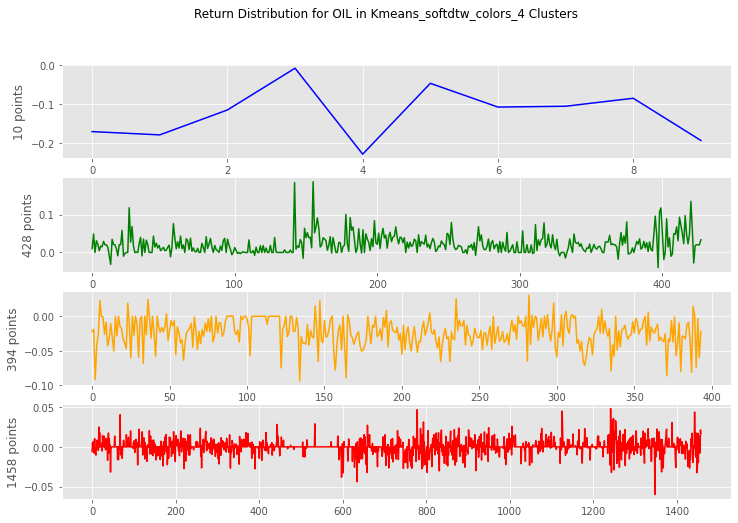

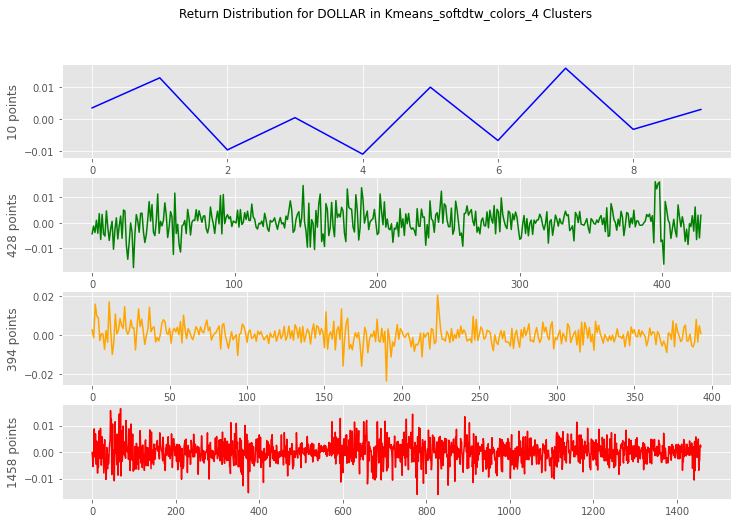

In [34]:
# show return data with label results
show_grouped_returns(df_change, df, CLOSES, COLORS)

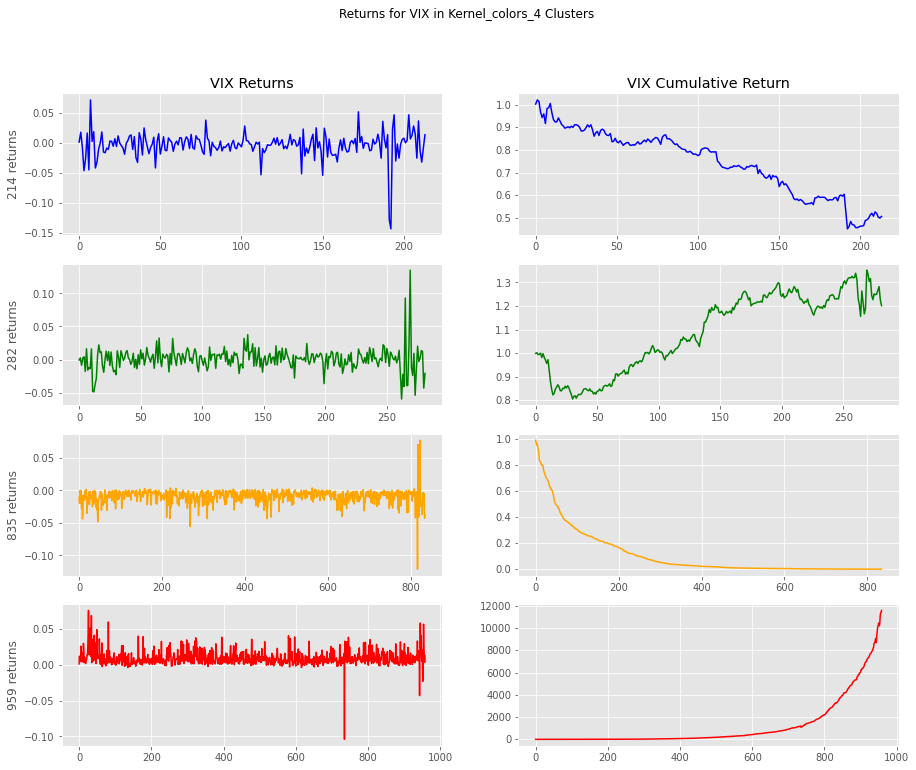

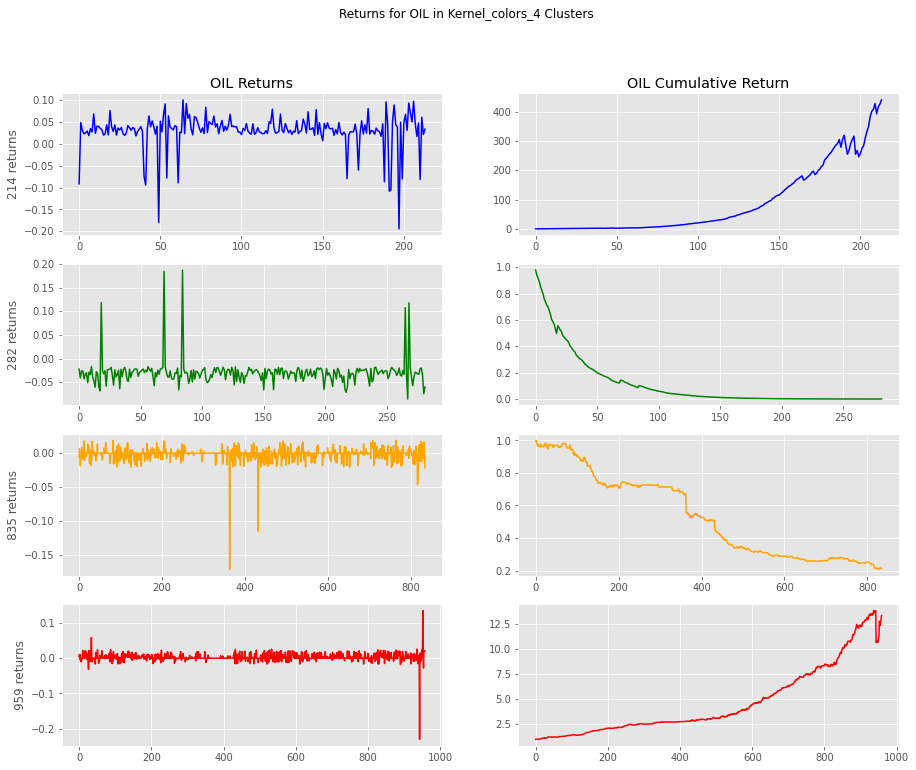

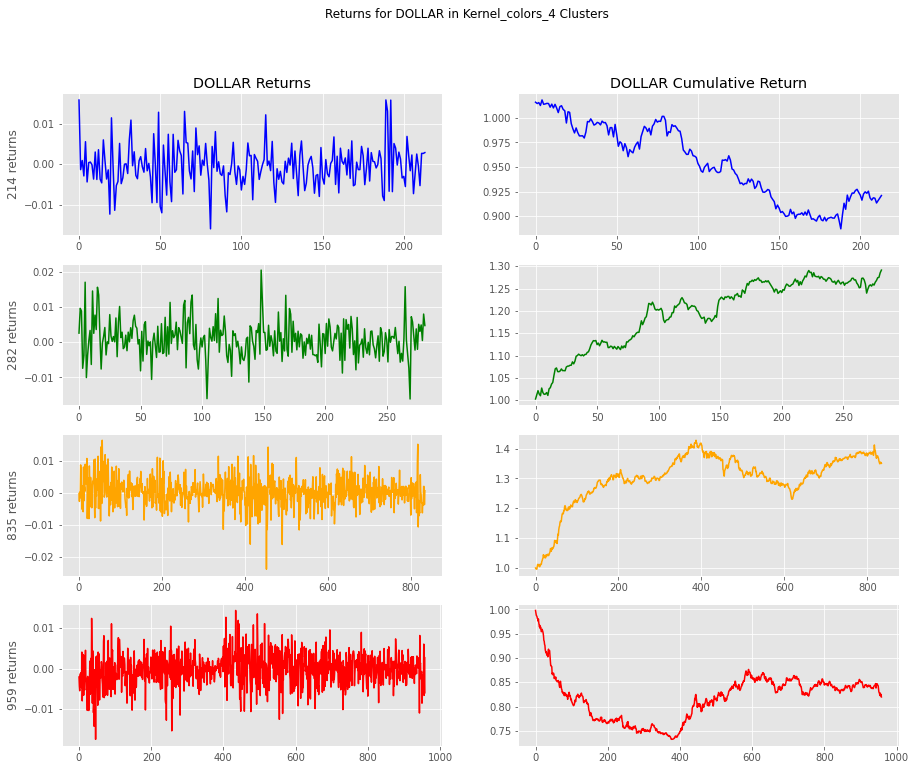

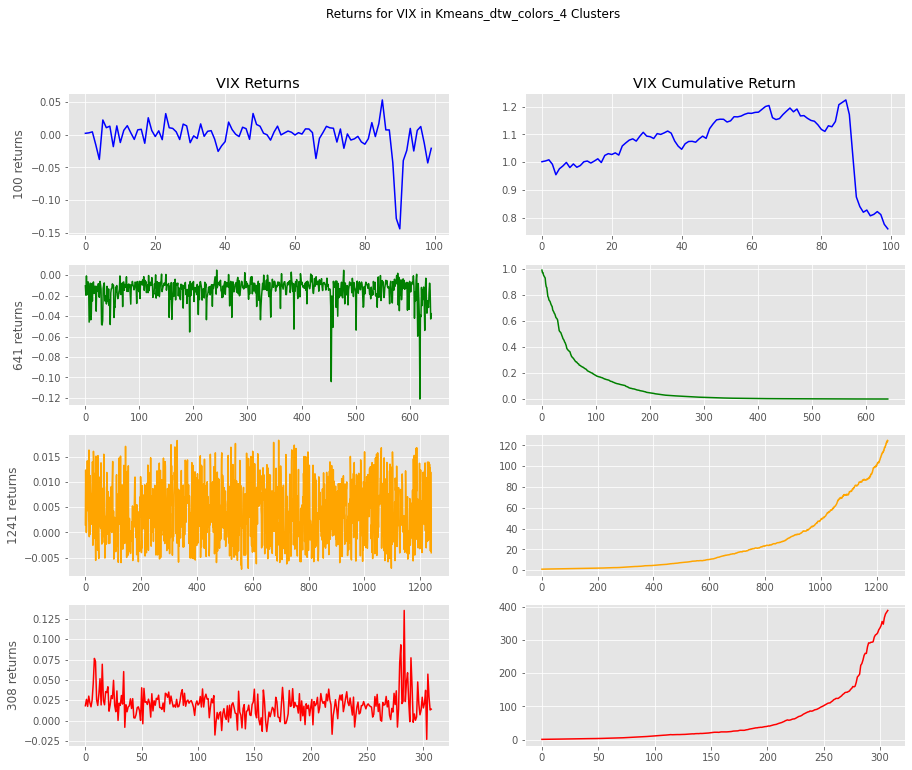

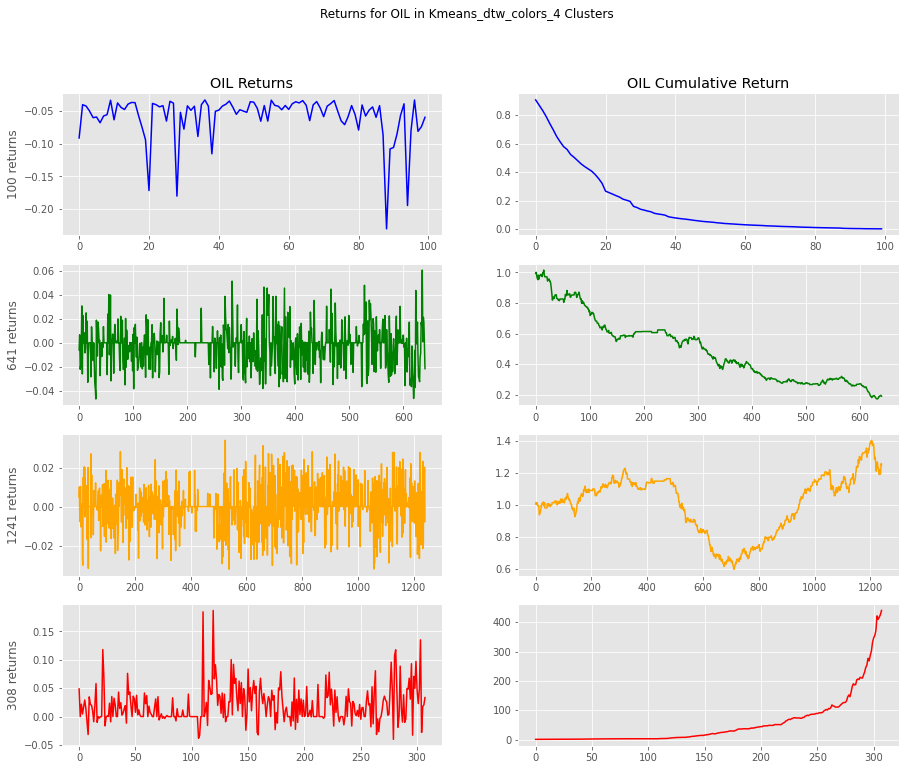

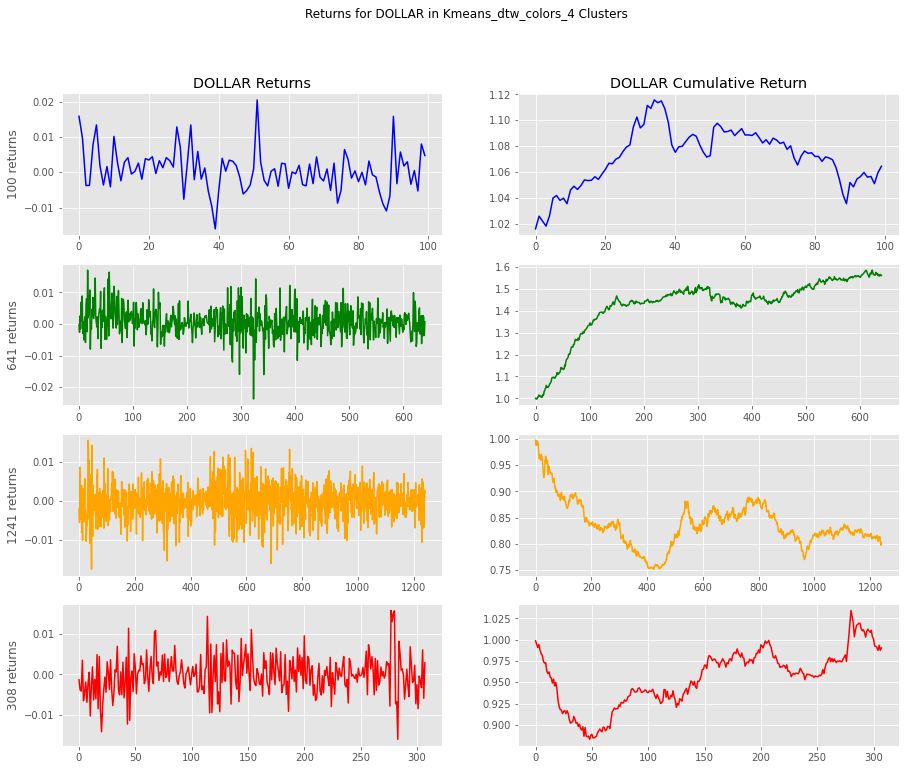

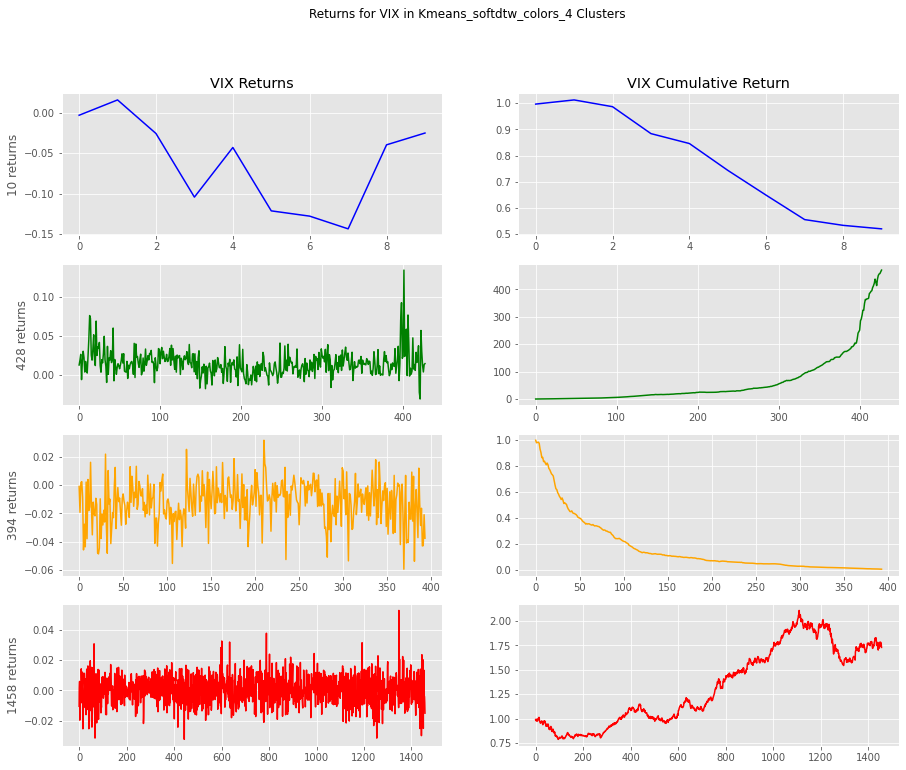

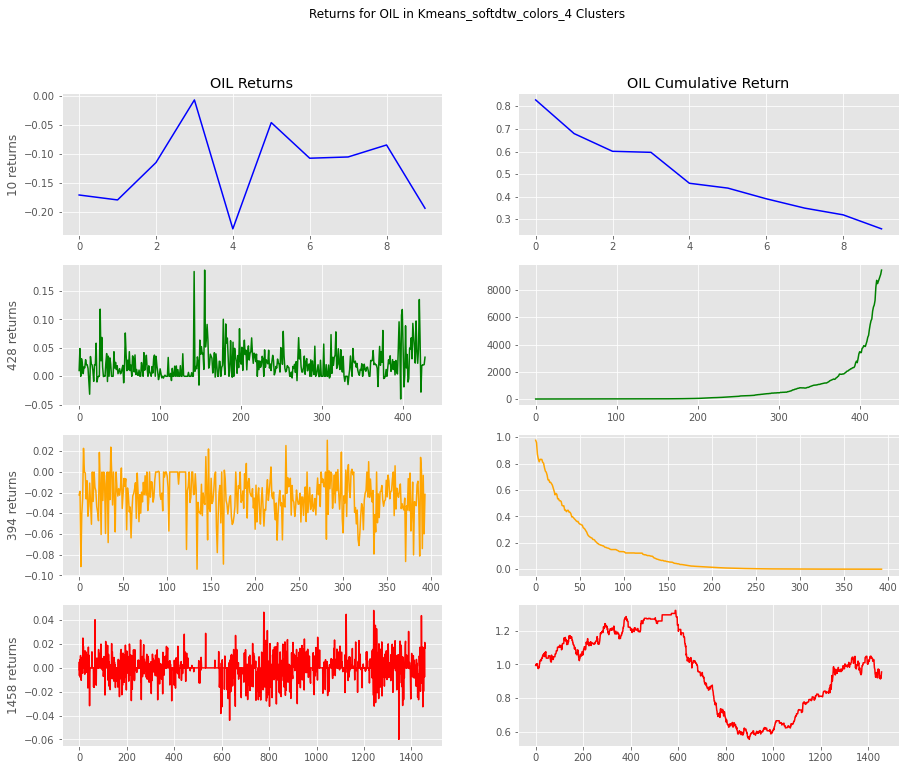

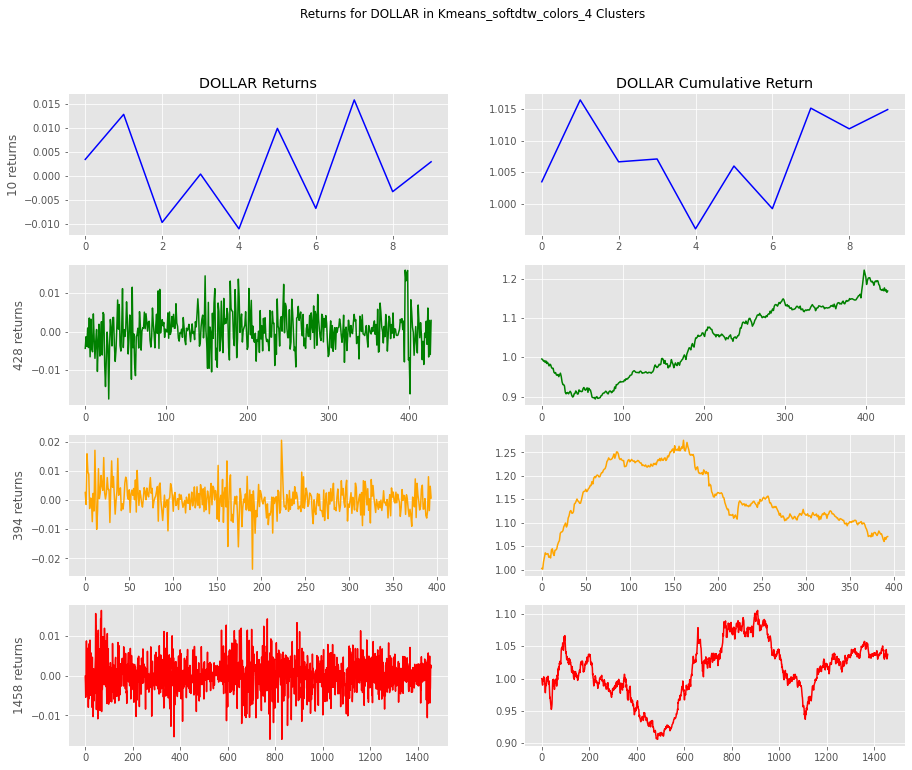

In [35]:
# show cumulative return data with label results
show_grouped_cumulative_return(df_change, df, CLOSES, COLORS)

In [45]:
# XGBoost Modeling
# Merge Data
df_merged = merge_data(vix, dollar, oil, credit_spread, monetary_base, 
                       period_spread, Year_1, Year_2, Year_10, TIPS, labels)

# Grid Search
# print best training, validation, and test accuracy with best set of hyperparemeters
XGB_Grid = XGBoost(grid=True, data=df_merged)

99.17952740957924 94.20274390243902 96.78662083553675 {'bylevel': 1, 'depth': 8, 'alpha': 2, 'estimators': 50}


10 cross validation training accuracy is 98.84310352732011
10 cross validation testing accuracy is 92.79777820885111


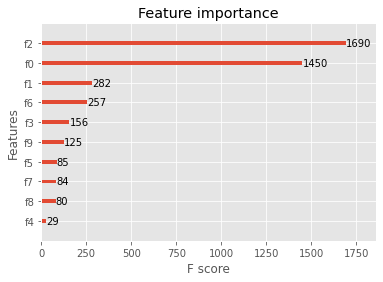

In [49]:
# Train the data with the best hyperparameter
XGB = XGBoost(grid=False, data=df_merged)
print("10 cross validation training accuracy is " + str(np.mean(XGB.training_acc_cv)))
print("10 cross validation testing accuracy is " + str(np.mean(XGB.testing_acc_cv)))

# Plot feature importance graph
# f2 : OIL
# f0 : VIX
# f1 : Dollar
# f6 : Year_1
# f3 : credit_spread
# f9 : TIPS
# f5 : period_spread
# f7 : Year_2
# f8 : Year_10
# f4 : monetary_base

plot_importance(XGB.model)
plt.show()